### Feature value analysis
### Feature values were extracted using the HALCON program "FeatureExtraction_0.1.0.hdev"

In [2]:
#Limit the number of files to be loaded
num_chips = 24 # Default value 24 for 2017-10-08_graphene_ALL
num_chips_def = 24
opt_outp_images = False;
n_scfactor = num_chips_def / num_chips

In [ ]:
# Importing the libraries
import platform, cv2, os, re, fnmatch, glob
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import scipy.ndimage as ndimage
import scipy
import scipy.ndimage.filters as filters
import scipy.stats as stats

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

from IPython.core.pylabtools import figsize
from os.path import expanduser

# The following command increases the resolution of the output figures
%config InlineBackend.figure_format='retina'

# List Font names for matplotlib
#
#font_paths = mpl.font_manager.findSystemFonts()
#font_objects = mpl.font_manager.createFontList(font_paths)
#font_names = [f.name for f in font_objects]
#print(font_names)
###


#Platform Version
print('Python Version:' + platform.python_version())
print('OpenCV Version' + cv2.__version__)

In [4]:
def find_all_files(directory):
    for root, dirs, files in os.walk(directory):
        yield root
        for file in files:
            yield os.path.join(root, file)
            
def get_image_list(path):
    file_list = []
    for (root, dirs, files) in os.walk(path): 
        for file in files: 
            target = os.path.join(root,file).replace("\\", "/")  
            if os.path.isfile(target): 
                if imghdr.what(target) != None : 
                    file_list.append(target) 
    return file_list

def find_image_files(files):
    for file in files:
        if fnmatch.fnmatch(file, '*.tiff'):
            yield file

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [5]:
def outp_images(outpdata, groupname):
    for index, row_it in outpdata.iterrows():
        root, ext = os.path.splitext(row_it['filename'])
        im = Image.open(root+'.jpg')
        row = row_it['row']
        row1 = row_it['row1']
        row2 = row_it['row2']
        column = row_it['column']
        column1 = row_it['column1']
        column2 = row_it['column2']
        crop_margin = 70
        
        width = column2 - column1 + crop_margin * 2
        height = row2 - row1 + crop_margin * 2

        aspect_ratio_width_to_height = 1.5
        
        # Rescale clip and crop area to the predefined aspect ratio
        if (width/height < aspect_ratio_width_to_height):
            width = height * aspect_ratio_width_to_height
        else:
            height = 1/aspect_ratio_width_to_height * width

        column1 = column - width/2
        column2 = column + width/2
        row1 = row - height/2
        row2 = row + height/2
        
        im_crop = im.crop((column1 , row1 , column2, row2))

        im_crop_resized = im_crop.resize((300,200))
        
        scale_factor = 300/width
        im_crop_resized.save('./out_images/' + groupname + 'cropped_scaled_%1.3f'%scale_factor 
                             + '.jpg', 'JPEG', quality=100, optimize=True)
        

In [6]:
def outp_images_with_mark(outpdata, groupname):
    os.mkdir('./out_images/' + groupname)
    for index, row_it in outpdata.iterrows():
        root, ext = os.path.splitext(row_it['filename'])
        im = Image.open(root+'.jpg')
        row = row_it['row']
        row1 = row_it['row1']
        row2 = row_it['row2']
        column = row_it['column']
        column1 = row_it['column1']
        column2 = row_it['column2']
        area = row_it['area']
        crop_margin = 70
        
        width = column2 - column1 + crop_margin * 2
        height = row2 - row1 + crop_margin * 2

        aspect_ratio_width_to_height = 1.5
        
        # Rescale clip and crop area to the predefined aspect ratio
        if (width/height < aspect_ratio_width_to_height):
            width = height * aspect_ratio_width_to_height
        else:
            height = 1/aspect_ratio_width_to_height * width

        column1 = column - width/2
        column2 = column + width/2
        row1 = row - height/2
        row2 = row + height/2
        
        vshift = 0
        hshift = 0
        if (column2 > im.width):
            hshift = -(column2 - im.width)
        elif (column1 < 0):
            hshift = -column1
        
        if (row2 > im.height):
            vshift = -(row2 - im.height)
        elif (row1 < 0):
            vshift = -row1
            
        im_crop = im.crop((column1 + hshift, row1 + vshift, column2 + hshift, row2 + vshift))

        #print ('%4d, %4d, %4d, %4d'%(column1 + hshift, row1 + vshift, column2 + hshift, row2 + vshift))
        width_resized = 300
        height_resized = 200
        im_crop_resized = im_crop.resize((width_resized,height_resized))
        
        im_crop_resized_draw = ImageDraw.Draw(im_crop_resized)
        
        scale_factor = 300/width
        vshift_scaled = scale_factor * vshift
        hshift_scaled = scale_factor * hshift
        
        r_sz = 3
        im_crop_resized_draw.line((150 - r_sz - hshift_scaled, 100 - r_sz - vshift_scaled,
                                   150 + r_sz - hshift_scaled, 100 - r_sz - vshift_scaled),fill=(255,0,0), width=1)
        im_crop_resized_draw.line((150 + r_sz - hshift_scaled, 100 - r_sz - vshift_scaled,
                                   150 + r_sz - hshift_scaled, 100 + r_sz - vshift_scaled),fill=(255,0,0), width=1)
        im_crop_resized_draw.line((150 + r_sz - hshift_scaled, 100 + r_sz - vshift_scaled,
                                   150 - r_sz - hshift_scaled, 100 + r_sz - vshift_scaled),fill=(255,0,0), width=1)
        im_crop_resized_draw.line((150 - r_sz - hshift_scaled, 100 + r_sz - vshift_scaled,
                                   150 - r_sz - hshift_scaled, 100 - r_sz - vshift_scaled),fill=(255,0,0), width=1)
        im_crop_resized.save('./out_images/' + groupname + '/' + groupname 
                             + 'cropped_scaled_marked_%06d_%1.3f'%(area, scale_factor) + '.jpg', 'JPEG',
                             quality=100, optimize=True)
        

In [7]:
#Set Default plotting styles

# Settings for seaboarn packages
sns.set()
#sns.set_style("whitegrid", {'grid.linestyle': '--', 'axes.linewidth':0.5,'axes.edgecolor':'black'})
sns.set_context("paper", 1.5, {"lines.linewidth": 4})
sns.set_palette("winter_r", 8, 1)
sns.set('paper', 'dark', font_scale=1.0, font='Arial')
sns.set_style('white')
#Settings on fonts
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['figure.titlesize'] = 6

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 0.5

#Settings on ticks
plt.rcParams['xtick.top']=True   # draw ticks on the top side
plt.rcParams['xtick.bottom']=True   # draw ticks on the bottom side
plt.rcParams['xtick.major.size']=4      # major tick size in points
plt.rcParams['xtick.minor.size']=2      # minor tick size in points
plt.rcParams['xtick.major.width']=0.5    # major tick width in points
plt.rcParams['xtick.minor.width']=0.5   # minor tick width in points
plt.rcParams['xtick.direction']='in'

plt.rcParams['ytick.left']=True   # draw ticks on the top side
plt.rcParams['ytick.right']=True   # draw ticks on the bottom side
plt.rcParams['ytick.major.size']=4      # major tick size in points
plt.rcParams['ytick.minor.size']=2      # minor tick size in points
plt.rcParams['ytick.major.width']=0.5    # major tick width in points
plt.rcParams['ytick.minor.width']=0.5   # minor tick width in points
plt.rcParams['ytick.direction']='in'

#Settings on figure resolution
plt.rcParams['savefig.dpi']=360

## Import the feature values

In [8]:
# Read Feature Values
df_files = pd.DataFrame(index=[], columns=['fullPath','filename','chipNo','features'])
parentFolder = expanduser("~") + '/projects/ImageProcessing/out/20180131_2017-10-08_graphene_ALL_004/'
#parentFolder = expanduser("~") + '/projects/ImageProcessing/out/20180212_2017-11-13-00110_Graphene_85nm_ALL_004/'

files = glob.glob(parentFolder+'*.txt')

for file in files:
    series=pd.Series([file, os.path.basename(file), int(os.path.basename(file)[0:2])
                      ,os.path.basename(file)[3:-4]], index = df_files.columns)
    df_files = df_files.append(series, ignore_index = True)

df_files_fnames = df_files.drop_duplicates(['features'])

df = pd.DataFrame(index=[], columns=[])

for index_i, row_i in df_files_fnames.iterrows():
    df_files_part_feat = df_files[
        df_files['features']==row_i['features']].sort_values(by='chipNo')
    df_files_part_feat = df_files_part_feat[df_files_part_feat['chipNo'] <= num_chips]

    df_tmp2 = pd.DataFrame(index = [], columns = [])
    for index_j, row_j in df_files_part_feat.iterrows():
        df_tmp = pd.read_csv(row_j['fullPath'], delimiter= ' ', header = None, skiprows = 1,
                            names = ['bit_length', row_j['features']])
        df_tmp2 = pd.concat([df_tmp2, df_tmp])
        print ('reading:' + row_j['filename'])
    
    df = pd.concat([df, df_tmp2.iloc[:,1]], axis = 1)

df = df.reset_index(drop=True)

df = df.sort_index(axis=1, ascending=True)
df = df.sort_values(by=["area"], ascending=False)

reading:01_rectangularity.txt
reading:02_rectangularity.txt
reading:03_rectangularity.txt
reading:04_rectangularity.txt
reading:05_rectangularity.txt
reading:06_rectangularity.txt
reading:07_rectangularity.txt
reading:08_rectangularity.txt
reading:09_rectangularity.txt
reading:10_rectangularity.txt
reading:11_rectangularity.txt
reading:12_rectangularity.txt
reading:13_rectangularity.txt
reading:14_rectangularity.txt
reading:15_rectangularity.txt
reading:16_rectangularity.txt
reading:17_rectangularity.txt
reading:18_rectangularity.txt
reading:19_rectangularity.txt
reading:20_rectangularity.txt
reading:21_rectangularity.txt
reading:22_rectangularity.txt
reading:23_rectangularity.txt
reading:24_rectangularity.txt
reading:01_median_v.txt
reading:02_median_v.txt
reading:03_median_v.txt
reading:04_median_v.txt
reading:05_median_v.txt
reading:06_median_v.txt
reading:07_median_v.txt
reading:08_median_v.txt
reading:09_median_v.txt
reading:10_median_v.txt
reading:11_median_v.txt
reading:12_media

In [9]:
# Extract the feature values subractes with the background values
df['mean_h_sub'] = df['mean_h'] - df['bg_mean_h']
df['mean_s_sub'] = df['mean_s'] - df['bg_mean_s']
df['mean_v_sub'] = df['mean_v'] - df['bg_mean_v']
df['mean_g_sub'] = df['mean_g'] - df['bg_mean_g']

df['median_h_sub'] = df['median_h'] - df['bg_median_h']
df['median_s_sub'] = df['median_s'] - df['bg_median_s']
df['median_v_sub'] = df['median_v'] - df['bg_median_v']
df['median_g_sub'] = df['median_g'] - df['bg_median_g']

# Plot the feature values

In [11]:
df_part0 = df[(-0.02 < df['median_v_sub']) & (df['median_v_sub'] < 0.02)]
df_part1 = df[(-0.055 < df['median_v_sub']) & (df['median_v_sub'] <= -0.02)]
df_part2 = df[(-0.09 < df['median_v_sub']) & (df['median_v_sub'] <= -0.055)]
df_part3 = df[(-0.12 < df['median_v_sub']) & (df['median_v_sub'] <= -0.09)]
df_part4 = df[(-0.15 < df['median_v_sub']) & (df['median_v_sub'] <= -0.12)]
df_part5 = df[(df['median_v_sub'] <= -0.15)]

df_part0_1 = df_part0[df_part0['median_h']<1.6]
df_part0_2 = df_part0[df_part0['median_h']>1.6]
df_part1_1 = df_part1[df_part1['median_h']<1.6]
df_part1_2 = df_part1[df_part1['median_h']>1.6]
df_part2_1 = df_part2[df_part2['median_h']<1.6]
df_part2_2 = df_part2[df_part2['median_h']>1.6]
df_part3_1 = df_part3[df_part3['median_h']<1.6]
df_part3_2 = df_part3[df_part3['median_h']>1.6]
df_part4_1 = df_part4[df_part4['median_h']<1.6]
df_part4_2 = df_part4[df_part4['median_h']>1.6]

df_part6 = df[(-0.4 < df['median_v_sub']) & (df['median_v_sub'] <= 0.02) & (df['median_h']>2.25)]

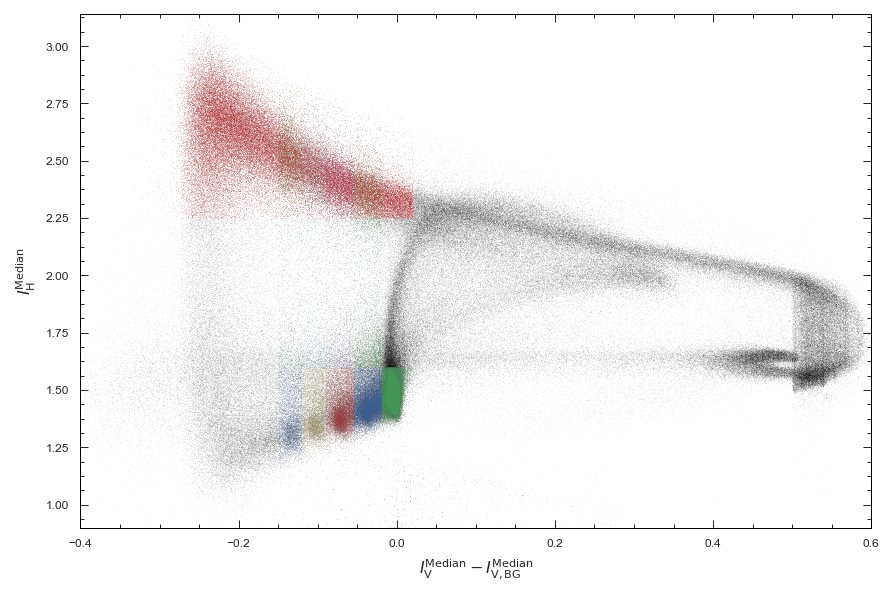

In [12]:
minorLocator1 = AutoMinorLocator()
minorLocator2 = AutoMinorLocator()

fig = plt.figure(figsize=cm2inch(18,12))

ax = plt.subplot(111)
#df.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=(df['area']/10000),alpha=0.5, figsize=(15, 10), color = 'k')
df.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'k')
df_part0_1.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C1')
df_part1_1.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C0')
df_part1_2.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C1')
df_part2_1.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C2')
df_part2_2.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C3')
df_part3_1.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C4')
df_part3_2.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C5')
df_part4_1.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C6')
df_part4_2.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'C7')
df_part6.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'median_h',s=0.001*n_scfactor,alpha=0.5, color = 'R')

ax.xaxis.set_minor_locator(minorLocator1)
ax.yaxis.set_minor_locator(minorLocator2)
ax.set_xlim(-0.4,0.6)
ax.set_ylim(0.9,3.14)
ax.set_xlabel('$\mathit{I}^\mathrm{Median}_\mathrm{V} - \mathit{I}^\mathrm{Median}_\mathrm{V, BG}$')
ax.set_ylabel('$\mathit{I}^\mathrm{Median}_\mathrm{H}$')

# plt.savefig('Figure3.png')
plt.show()

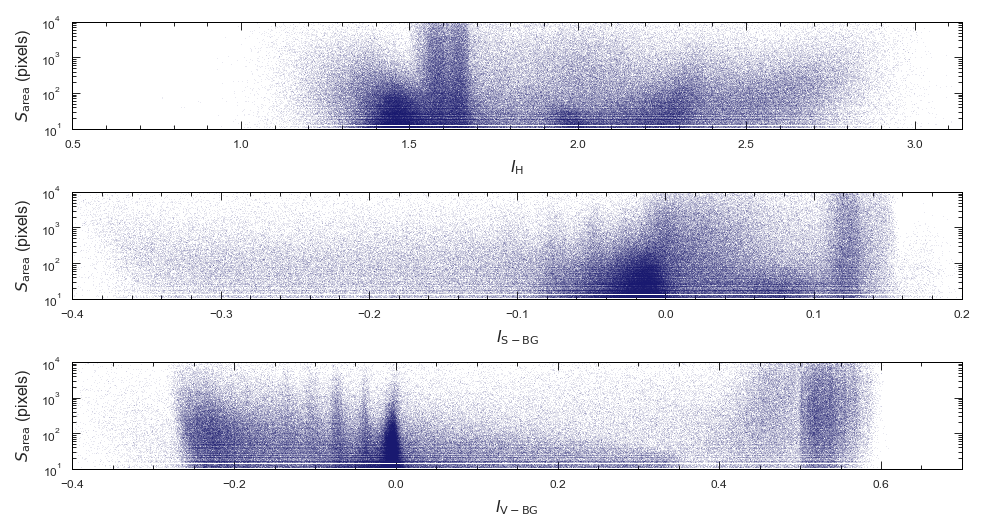

In [13]:
# 各領域の中央値(median) vs. Areaプロット (log version)
minorLocator1 = AutoMinorLocator()
minorLocator2 = AutoMinorLocator()
minorLocator3 = AutoMinorLocator()
#minorLocator4 = AutoMinorLocator()

fig = plt.figure(figsize=cm2inch(17,9))

ax = plt.subplot(311)
df.plot(kind='scatter', x=u'median_h',ax=ax, y=u'area',s=0.001*n_scfactor, logy=True, c='midnightblue')
ax.set_ylim(10,10000)
ax.set_xlim(0.5,3.14)
ax.xaxis.set_minor_locator(minorLocator1)
ax.set_ylabel('$\mathit{S}_\mathrm{area}$ (pixels)')
ax.set_xlabel('$\mathit{I}_\mathrm{H}$')

ax = plt.subplot(312)
df.plot(kind='scatter', x=u'median_s_sub',ax=ax, y=u'area',s=0.001*n_scfactor, logy=True, c='midnightblue')
ax.autoscale(enable=True, axis='y')
ax.set_ylim(10,10000)
ax.set_xlim(-0.4,0.2)
ax.xaxis.set_minor_locator(minorLocator2)
ax.set_ylabel('$\mathit{S}_\mathrm{area}$ (pixels)')
ax.set_xlabel('$\mathit{I}_\mathrm{S-BG}$')

ax = plt.subplot(313)
df.plot(kind='scatter', x=u'median_v_sub',ax=ax, y=u'area',s=0.001*n_scfactor, logy=True, c='midnightblue')
ax.set_ylim(10,10000)
ax.set_xlim(-0.4,0.7)
ax.xaxis.set_minor_locator(minorLocator3)
#ax.autoscale(enable=True,axis='y')
ax.set_ylabel('$\mathit{S}_\mathrm{area}$ (pixels)')
ax.set_xlabel('$\mathit{I}_\mathrm{V-BG}$')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.savefig('%02d_Figure1B.png'%num_chips)

plt.show()

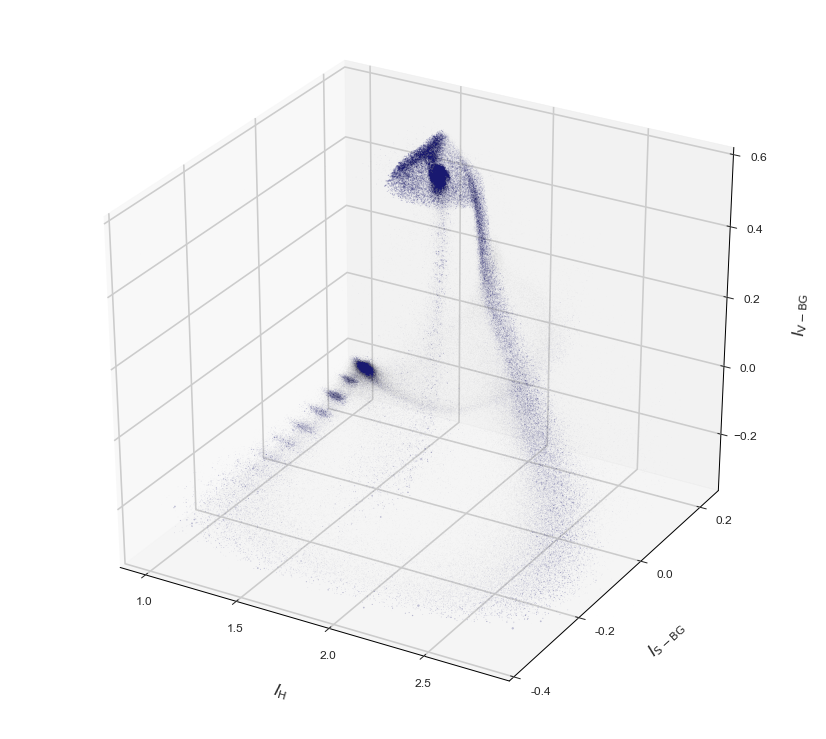

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=cm2inch(13,13))
ax = plt.subplot(111,projection='3d')
xs = df['median_h'].as_matrix()
ys = df['median_s_sub'].as_matrix()
zs = df['median_v_sub'].as_matrix()
areas = df['area'].as_matrix()
ax.scatter(xs,ys,zs, s = areas/300000*n_scfactor, alpha = 0.2, c='midnightblue')
ax.set_xlim3d(0.9,2.9)
ax.set_ylim3d(-0.4,0.25)
ax.set_zlim3d(-0.35,0.6)
ax.set_xlabel('$\mathit{I}_\mathrm{H}$')
ax.set_ylabel('$\mathit{I}_\mathrm{S-BG}$')
ax.set_zlabel('$\mathit{I}_\mathrm{V-BG}$')

ax.set_xticks([1.0,1.5,2.0,2.5])
ax.set_yticks([-0.4,-0.2, 0, 0.2])
ax.margins(x=0, y=0, z=0)
ax.set_xticklabels(ax.get_xticks(),va='top', ha='left')
ax.set_yticklabels(ax.get_yticks(),va='bottom', ha='left')
#ax.set_zticklabels(ax.get_zticks(),va='bottom', ha='left')

ax.tick_params(axis='x',pad=.1)
ax.tick_params(axis='y',pad=.1)
ax.tick_params(axis='z',pad=.1)

ax.yaxis._axinfo['label']['space_factor'] = 0.1

#Set the elevation and azimuth of the axes.
#ax.view_init(8,-55)
plt.tight_layout()

#fig.subplots_adjust(right=0.1)
fig.subplots_adjust(left=-0.1)

plt.savefig('%02d_Figure2a.png'%num_chips)
plt.show()

In [ ]:
# Generate histogram

range_start_v_sub = -0.45
range_stop_v_sub = 0.6
numbins_v_sub = 300
bins_center_v_sub = np.linspace(range_start_v_sub, range_stop_v_sub, numbins_v_sub)
bin_step_v_sub = bins_center_v_sub[1]-bins_center_v_sub[0]

range_start_h = 1.0
range_stop_h = 3.14
numbins_h = 300
bins_center_h = np.linspace(range_start_h, range_stop_h, numbins_h)
bin_step_h = bins_center_h[1]-bins_center_h[0]

area_sum_hv = np.zeros((numbins_v_sub, numbins_h))

for (i,bin_center_h) in enumerate(bins_center_h):
    bin_lb_h = bin_center_h - bin_step_h/2
    bin_ub_h = bin_center_h + bin_step_h/2
    df_part = df[(bin_lb_h < df['median_h']) & (df['median_h'] <= bin_ub_h)]
    for(j,bin_center_v_sub) in enumerate(bins_center_v_sub):
        bin_lb_v_sub = bin_center_v_sub - bin_step_v_sub/2
        bin_ub_v_sub = bin_center_v_sub + bin_step_v_sub/2
        df_part_part =df_part[(bin_lb_v_sub < df_part['median_v_sub']) & (df_part['median_v_sub'] <= bin_ub_v_sub)]
        area_sum_hv[j,i] = df_part_part['area'].sum()
    #print(i)
    
area_sum_log_hv = np.log10(area_sum_hv)
area_sum_log_hv[np.isinf(area_sum_log_hv)]=-1

In [17]:
# Filter area_sum_log_hv by gaussian
sigma_y = 1.0
sigma_x = 1.0

sigma = [sigma_y,sigma_x]
area_sum_log_hv_filt = sp.ndimage.filters.gaussian_filter(area_sum_log_hv,sigma,mode='constant')

neighborhood_size = 10
threshold = 0.8

# Find local maxima
data_max = filters.maximum_filter(area_sum_log_hv_filt, neighborhood_size)
maxima = (area_sum_log_hv_filt == data_max)
data_min = filters.minimum_filter(area_sum_log_hv_filt, neighborhood_size)
diff=((data_max - data_min)>threshold)
maxima[diff==0]=0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
xs, ys = [], []
for dy, dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    xs.append(x_center)
    y_center = (dy.start + dy.stop -1)/2
    ys.append(y_center)

xs_h=[]
for x in xs:
    xs_h.append(bins_center_h[np.round(x).astype(int)])

ys_v_sub=[]
for y in ys:
    ys_v_sub.append(bins_center_v_sub[np.round(y).astype(int)])

su_lo = area_sum_hv[:,0:110].sum(axis=1)
su_hi = area_sum_hv[:,110:299].sum(axis=1)

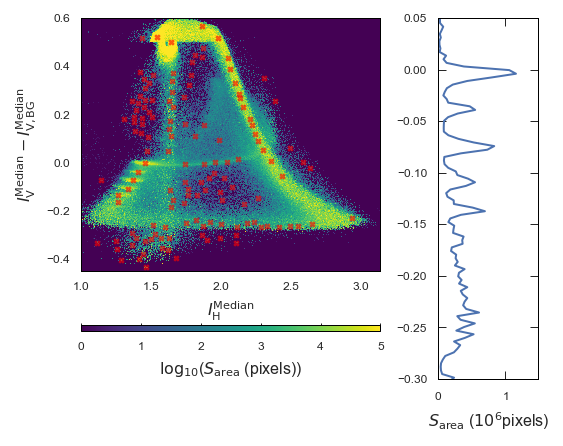

In [18]:
from matplotlib.ticker import ScalarFormatter
X, Y = np.meshgrid(bins_center_h, bins_center_v_sub)

plt.figure(figsize=cm2inch(10.0,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

ax = plt.subplot(gs[0])
p =plt.pcolor(X, Y, area_sum_log_hv, cmap = 'viridis', vmin = 0, vmax = 5)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])
ax.set_xlabel('$\mathit{I}^\mathrm{Median}_\mathrm{H}$')
ax.set_ylabel('$\mathit{I}^\mathrm{Median}_\mathrm{V} - \mathit{I}^\mathrm{Median}_\mathrm{V, BG}$')
cbar = plt.colorbar(p, ax=ax, aspect=50, orientation = 'horizontal')
cbar.set_label('$\mathrm{log}_{10}$(${S}_\mathrm{area}$ (pixels))')
plt.scatter(xs_h,ys_v_sub,c='r', marker='X',s=8, alpha=0.6)

ax = plt.subplot(gs[1])
su_lo_scaled = su_lo/1E6
p = ax.plot(su_lo_scaled, bins_center_v_sub, lw=1)
ax.set_ylim(-0.3, 0.05)
ax.set_xlim(0,1.5/n_scfactor)
ax.set_xlabel('${S}_\mathrm{area}$ ($10^6$pixels)')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.savefig('%02d_FigureS3.png'%num_chips)
plt.show()

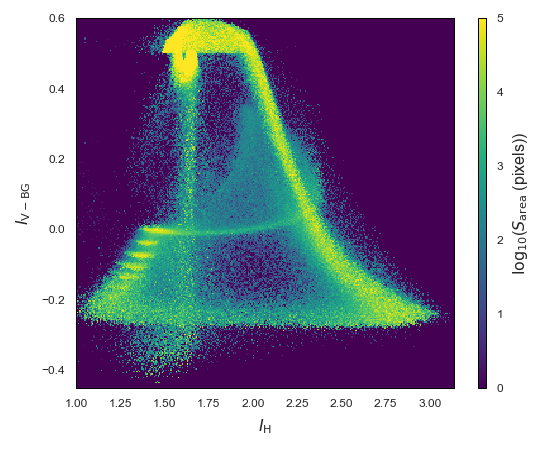

In [19]:
from matplotlib.ticker import ScalarFormatter
X, Y = np.meshgrid(bins_center_h, bins_center_v_sub)
minorLocatorX = AutoMinorLocator()
minorLocatorY = AutoMinorLocator()

plt.figure(figsize=cm2inch(10,8))

ax = plt.subplot(111)
p =plt.pcolor(X, Y, area_sum_log_hv, cmap = 'viridis', vmin = 0, vmax = 5)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])
ax.set_xlabel('$\mathit{I}_\mathrm{H}$')
ax.set_ylabel('$\mathit{I}_\mathrm{V-BG}$')
cbar = plt.colorbar(p, ax=ax, aspect=50, orientation = 'vertical')
cbar.set_label('$\mathrm{log}_{10}$(${S}_\mathrm{area}$ (pixels))')
ax.xaxis.set_minor_locator(minorLocatorX)
ax.yaxis.set_minor_locator(minorLocatorY)

#plt.scatter(xs_h,ys_v_sub,c='r', marker='X',s=8, alpha=0.6)

plt.tight_layout()
plt.savefig('%02d_Figure3a.png'%num_chips)
plt.show()

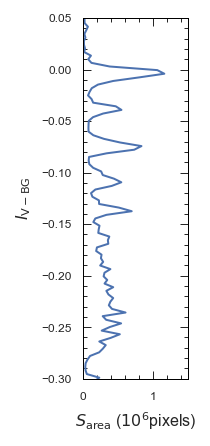

In [20]:
plt.figure(figsize=cm2inch(3.8,8))
minorLocatorX = AutoMinorLocator()
minorLocatorY = AutoMinorLocator()

ax = plt.subplot(111)
su_lo_scaled = su_lo/1E6
p = ax.plot(su_lo_scaled, bins_center_v_sub, lw=1)
ax.set_ylim(-0.3, 0.05)
ax.set_xlim(0,1.5/n_scfactor)
ax.set_xlabel('${S}_\mathrm{area}$ ($10^6$pixels)')
ax.set_ylabel('$\mathit{I}_\mathrm{V-BG}$')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.xaxis.set_minor_locator(minorLocatorX)
ax.yaxis.set_minor_locator(minorLocatorY)
plt.tight_layout()
plt.savefig('%02d_Figure3b.png'%num_chips)
plt.show()

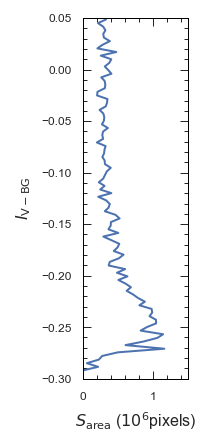

In [21]:
plt.figure(figsize=cm2inch(3.8,8))
minorLocatorX = AutoMinorLocator()
minorLocatorY = AutoMinorLocator()

ax = plt.subplot(111)
su_hi_scaled = su_hi/1E6
p = ax.plot(su_hi_scaled, bins_center_v_sub, lw=1)
ax.set_ylim(-0.3, 0.05)
ax.set_xlim(0,1.5/n_scfactor)
ax.set_xlabel('${S}_\mathrm{area}$ ($10^6$pixels)')
ax.set_ylabel('$\mathit{I}_\mathrm{V-BG}$')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.xaxis.set_minor_locator(minorLocatorX)
ax.yaxis.set_minor_locator(minorLocatorY)
plt.tight_layout()
plt.savefig('%02d_Figure3c.png'%num_chips)
plt.show()

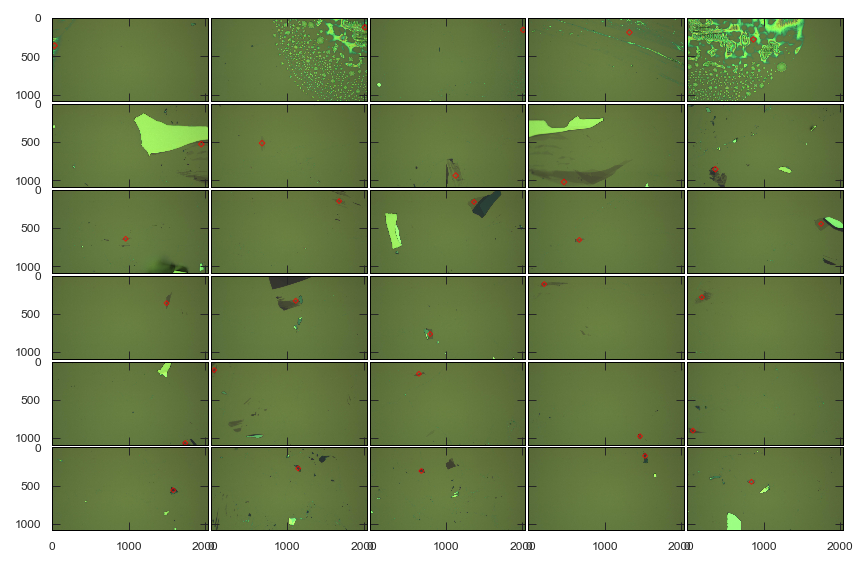

In [22]:
from PIL import Image, ImageDraw
from mpl_toolkits.axes_grid1 import ImageGrid

num_of_imgs = 5

fig = plt.figure(figsize=cm2inch(18,18))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(6, num_of_imgs))

area_th = 1000


i=0
j=0
for index, row in df_part0_1[area_th< df_part0_1['area']].sample(n=num_of_imgs).iterrows():
    #print ('Filename:' + row['filename'])
    root, ext = os.path.splitext(row['filename'])
    im = Image.open(root+'.jpg')
    ax = grid[i*num_of_imgs+j]
    ax.scatter(row['column'],row['row'],marker='D', color='red', facecolors="None",
               linewidths=0.5,
               alpha=0.8, s=4,
               label='Class%d-%d'%(i,j))
    ax.imshow(im)
    #print (index)
    j=j+1

i=1
j=0
for index, row in df_part1_1[area_th< df_part1_1['area']].sample(n=num_of_imgs).iterrows():
    #print ('Filename:' + row['filename'])
    root, ext = os.path.splitext(row['filename'])
    im = Image.open(root+'.jpg')
    ax = grid[i*num_of_imgs+j]
    ax.scatter(row['column'],row['row'],marker='D', color='red', facecolors="None",
               linewidths=0.5,
               alpha=0.8, s=4,
               label='Class%d-%d'%(i,j))
    ax.imshow(im)
    #print (index)
    j=j+1

i=2
j=0
for index, row in df_part2_1[area_th < df_part2_1['area']].sample(n=num_of_imgs).iterrows():
    #print ('Filename:' + row['filename'])
    root, ext = os.path.splitext(row['filename'])
    im = Image.open(root+'.jpg')
    ax = grid[i*num_of_imgs+j]
    ax.scatter(row['column'],row['row'],marker='D', color='red', facecolors="None",
               linewidths=0.5,
               alpha=0.8, s=3,
               label='Class%d-%d'%(i,j))
    ax.imshow(im)
    #print (index)
    j=j+1

i=3
j=0
for index, row in df_part3_1[area_th < df_part3_1['area']].sample(n=num_of_imgs).iterrows():
    #print ('Filename:' + row['filename'])
    root, ext = os.path.splitext(row['filename'])
    im = Image.open(root+'.jpg')
    ax = grid[i*num_of_imgs+j]
    ax.scatter(row['column'],row['row'],marker='D', color='red', facecolors="None",
               linewidths=0.5,
               alpha=0.8, s=3,
               label='Class%d-%d'%(i,j))
    ax.imshow(im)
    #print (index)
    j=j+1

i=4
j=0
for index, row in df_part4_1[area_th < df_part4_1['area']].sample(n=num_of_imgs).iterrows():
    #print ('Filename:' + row['filename'])
    root, ext = os.path.splitext(row['filename'])
    im = Image.open(root+'.jpg')
    ax = grid[i*num_of_imgs+j]
    ax.scatter(row['column'],row['row'],marker='D', color='red', facecolors="None",
               linewidths=0.5,
               alpha=0.8, s=3,
               label='Class%d-%d'%(i,j))
    ax.imshow(im)
    #print (index)
    j=j+1

i=5
j=0
for index, row in df_part6[area_th < df_part6['area']].sample(n=num_of_imgs).iterrows():
    #print ('Filename:' + row['filename'])
    root, ext = os.path.splitext(row['filename'])
    im = Image.open(root+'.jpg')
    ax = grid[i*num_of_imgs+j]
    ax.scatter(row['column'],row['row'],marker='D', color='red', facecolors="None",
               linewidths=0.5,
               alpha=0.8, s=3,
               label='Class%d-%d'%(i,j))
    ax.imshow(im)
    #print (index)
    j=j+1

#plt.savefig('Figure3_%02d_thumbnail.png'%num_chips)
plt.show()

In [23]:
#outp_images(df_part0_1[area_th < df_part0_1['area']], 'part0_1')
#outp_images(df_part1_1[area_th < df_part1_1['area']], 'part1_1')
#outp_images(df_part2_1[area_th < df_part2_1['area']], 'part2_1')
#outp_images(df_part3_1[area_th < df_part3_1['area']], 'part3_1')
#outp_images(df_part4_1[area_th < df_part4_1['area']], 'part4_1')
#outp_images(df_part6[area_th < df_part6['area']], 'part6')

In [24]:
area_th=500

In [25]:
if opt_outp_images :
    outp_images_with_mark(df_part0_1[area_th < df_part0_1['area']], 'part0_1')
    outp_images_with_mark(df_part1_1[area_th < df_part1_1['area']], 'part1_1')
    outp_images_with_mark(df_part2_1[area_th < df_part2_1['area']], 'part2_1')
    outp_images_with_mark(df_part3_1[area_th < df_part3_1['area']], 'part3_1')
    outp_images_with_mark(df_part4_1[area_th < df_part4_1['area']], 'part4_1')
    outp_images_with_mark(df_part6[area_th < df_part6['area']], 'part6')

# Generate data for fitting

## Weak Reduction  -> For Gaussian Mixutures

In [26]:
median_h_max_thresh = 1.6
median_v_sub_max_thresh = 0.1

In [27]:
df_part = df[(df['median_h']<median_h_max_thresh) & (df['median_v_sub'] < median_v_sub_max_thresh)]
df_part_part = df_part[['area','median_h','median_v_sub']]
array = df_part_part.as_matrix()

# Scale area by reduction_factor to reduce the data number
reduction_factor = 200/n_scfactor
array[:,[0]]=array[:,[0]]/reduction_factor

X_to_fit = np.empty((0,2),float)

for row in array:
    if np.round(row[0]).astype(np.integer) != 0:
        arr_tmp = np.array([[row[2],row[1]]] * np.round(row[0]).astype(np.integer))
        X_to_fit = np.vstack([X_to_fit, arr_tmp]) 

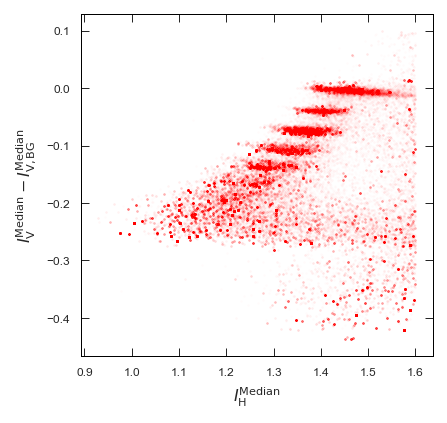

Number of Datapoints: 243158


In [28]:
plt.figure(figsize=cm2inch(8,8))
ax = plt.subplot(111)
plt.scatter(X_to_fit[:,1],X_to_fit[:,0],.8, color='r', alpha=0.015)
ax.set_xlabel('$\mathit{I}^\mathrm{Median}_\mathrm{H}$')
ax.set_ylabel('$\mathit{I}^\mathrm{Median}_\mathrm{V} - \mathit{I}^\mathrm{Median}_\mathrm{V, BG}$')
plt.show()

print('Number of Datapoints: %d' % X_to_fit.size)

In [29]:
# Count number of peaks within the selected range 
# Filter area_sum_log_hv by gaussian
sigma_y = 1.5
sigma_x = 1.5

sigma = [sigma_y,sigma_x]
area_sum_log_hv_filt = sp.ndimage.filters.gaussian_filter(area_sum_log_hv,sigma,mode='constant')

neighborhood_size = 10
threshold = 0.5

# Find local maxima
data_max = filters.maximum_filter(area_sum_log_hv_filt, neighborhood_size)
maxima = (area_sum_log_hv_filt == data_max)
data_min = filters.minimum_filter(area_sum_log_hv_filt, neighborhood_size)
diff=((data_max - data_min)>threshold)
maxima[diff==0]=0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
xs, ys = [], []
for dy, dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    xs.append(x_center)
    y_center = (dy.start + dy.stop -1)/2
    ys.append(y_center)

xs_h=[]
for x in xs:
    xs_h.append(bins_center_h[np.round(x).astype(int)])

ys_v_sub=[]
for y in ys:
    ys_v_sub.append(bins_center_v_sub[np.round(y).astype(int)])

su_lo = area_sum_hv[:,0:110].sum(axis=1)
su_hi = area_sum_hv[:,110:299].sum(axis=1)

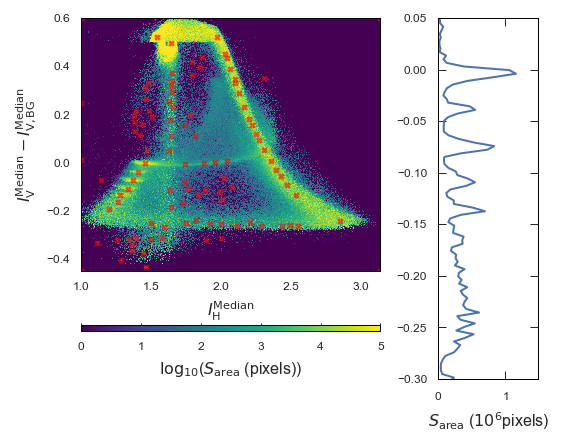

In [30]:
from matplotlib.ticker import ScalarFormatter
X, Y = np.meshgrid(bins_center_h, bins_center_v_sub)

plt.figure(figsize=cm2inch(10.0,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 

ax = plt.subplot(gs[0])
p =plt.pcolor(X, Y, area_sum_log_hv, cmap = 'viridis', vmin = 0, vmax = 5)
plt.axis([X.min(), X.max(), Y.min(), Y.max()])
ax.set_xlabel('$\mathit{I}^\mathrm{Median}_\mathrm{H}$')
ax.set_ylabel('$\mathit{I}^\mathrm{Median}_\mathrm{V} - \mathit{I}^\mathrm{Median}_\mathrm{V, BG}$')
cbar = plt.colorbar(p, ax=ax, aspect=50, orientation = 'horizontal')
cbar.set_label('$\mathrm{log}_{10}$(${S}_\mathrm{area}$ (pixels))')
plt.scatter(xs_h,ys_v_sub,c='r', marker='X',s=8, alpha=0.6)

ax = plt.subplot(gs[1])
su_lo_scaled = su_lo/1E6
p = ax.plot(su_lo_scaled, bins_center_v_sub, lw=1)
ax.set_ylim(-0.3, 0.05)
ax.set_xlim(0,1.5/n_scfactor)
ax.set_xlabel('${S}_\mathrm{area}$ ($10^6$pixels)')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
#plt.savefig('Figure4A_%02d.png'%num_chips)
plt.show()

In [31]:
num_clusters = 0
means_init = np.empty((0,2),float)
xs_init = []
ys_init = []
for index, x in enumerate(xs_h):
    if (x < median_h_max_thresh) & (ys_v_sub[index] < median_v_sub_max_thresh):
        xs_init.append(x)
        ys_init.append(ys_v_sub[index])
        num_clusters += 1

means_init_ = np.transpose(np.array([ys_init,xs_init]))

In [32]:
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

index_str='abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Model1: Gaussian Mixture Model 

In [33]:
gmm = mixture.GaussianMixture(
    n_components=num_clusters,
    covariance_type='full',
    means_init=means_init_,
    tol=1e-4,
    max_iter=100000).fit(X_to_fit)

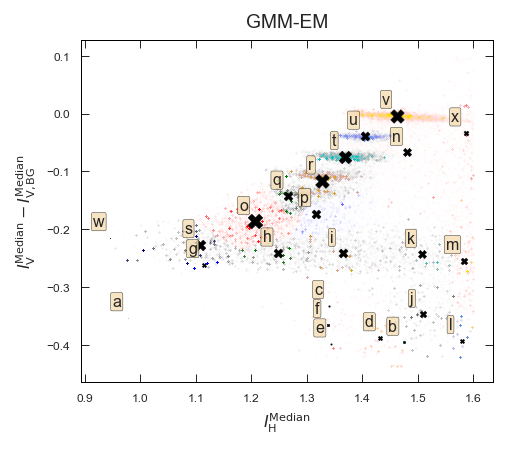

In [34]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'r', 'b','g', 'goldenrod'])

def plot_results(X, Y_, means, covariances, weights, means_init):
    ax = plt.subplot(1, 1, 1)
    for i, (mean, covar, weight, color, mean_init) in enumerate(zip(
            means, covariances, weights, color_iter, means_init)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 1], X[Y_ == i, 0], 1, color=color, alpha = 0.002*n_scfactor)

        # Plot an ellipse to show the Gaussian component
        angle = -np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse([mean[1],mean[0]], v[1], v[0], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.3)
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.1)
        
        ax.text(mean[1]-0.02,mean[0]+0.02,index_str[i], horizontalalignment='center', fontsize=8, bbox=props)
        #ax.add_artist(ell)
        #ax.scatter(mean_init[1],mean_init[0], marker='X',c = color, edgecolors='black', s=weight*400, alpha = 1)
        ax.scatter(mean[1],mean[0], marker='X',c = 'black', edgecolors='black', s=weight*400, alpha = 1)

    ax.set_xlabel('$\mathit{I}^\mathrm{Median}_\mathrm{H}$')
    ax.set_ylabel('$\mathit{I}^\mathrm{Median}_\mathrm{V} - \mathit{I}^\mathrm{Median}_\mathrm{V, BG}$')
    ax.set_title('GMM-EM')
plt.figure(figsize=cm2inch(9,8))
plot_results(X_to_fit, gmm.predict(X_to_fit), gmm.means_, gmm.covariances_, gmm.weights_, gmm.means_init)
plt.tight_layout()
plt.savefig('%02d_FigureS4_GMM.png'%num_chips)
plt.show()

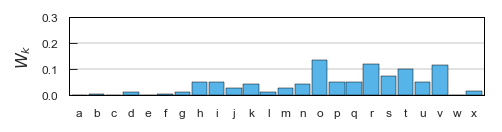

In [35]:
plt.figure(figsize=cm2inch(9,2))

ax = plt.subplot(1,1,1)
ax.get_xaxis().set_tick_params(direction='out')
ax.yaxis.grid(True, alpha=0.7)
for k, w in enumerate(gmm.weights_):
    ax.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
            align='center', edgecolor='black')
    #ax.text(k, w + 0.007, "%.1f%%" % (w * 100.),
    #        horizontalalignment='center')
    ax.text(k, -0.08, index_str[k], horizontalalignment='center')
    ax.set_xlim(-.6, gmm.n_components - .4)
    ax.set_ylim(0., 0.3)
    ax.tick_params(axis='y', which='both', left='on',
                    right='off', labelleft='on')
    ax.tick_params(axis='x', which='both', top='off',
                   bottom='off', labelbottom='off')

ax.set_ylabel('$W_k$')

plt.tight_layout()
plt.savefig('%02d_FigureS4_GMM_Weights.png'%num_chips)
plt.show()

# Model2: Bayesian Gaussian Mixutre Model with Dirichlet Process

In [36]:
dpgmm = mixture.BayesianGaussianMixture(
    n_components=num_clusters,
    covariance_type='full',
    weight_concentration_prior=1e+0,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e1,
    init_params = 'kmeans',
    #covariance_prior=1e0 * np.eye(2) 
    max_iter=10000).fit(X_to_fit)

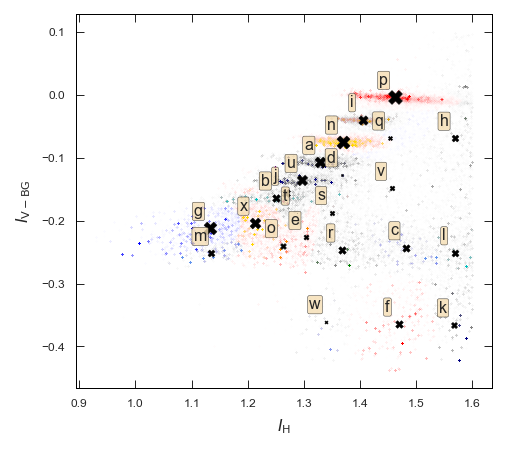

In [37]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'r', 'b','g', 'goldenrod', 'purple'])

plt.figure(figsize=cm2inch(9,8))

means = dpgmm.means_
covariances = dpgmm.covariances_
weights = dpgmm.weights_

X = X_to_fit
Y_ = dpgmm.predict(X_to_fit)
ax = plt.subplot(1, 1, 1)
for i, (mean, covar, weight, color) in enumerate(zip(
    means, covariances, weights, color_iter)):
    v, w = linalg.eigh(covar)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    
    if not np.any(Y_ == i):
        continue

    plt.scatter(X[Y_ == i, 1], X[Y_ == i, 0], 1, color=color, alpha = 0.002*n_scfactor)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.1)
    ax.text(mean[1]-0.02,mean[0]+0.02,index_str[i], horizontalalignment='center', fontsize=8, bbox=props)
    #Plot cluster center
    ax.scatter(mean[1],mean[0], marker='X',c = 'black', edgecolors='black', s=weight*400, alpha = 1)
    

    # Plot an ellipse to show the Gaussian component
    angle = -np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse([mean[1],mean[0]], v[1], v[0], 180. + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.3)
    #ax.add_artist(ell)

ax.set_xlabel('$\mathit{I}_\mathrm{H}$')
ax.set_ylabel('$\mathit{I}_\mathrm{V-BG}$')
plt.tight_layout()
plt.savefig('%02d_Figure5_DPGMM.png'%num_chips)
plt.show()

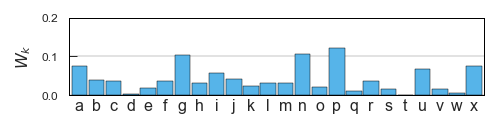

In [38]:
plt.figure(figsize=cm2inch(9,2))

ax = plt.subplot(1,1,1)
ax.get_xaxis().set_tick_params(direction='out')
ax.yaxis.grid(True, alpha=0.7)
for k, w in enumerate(dpgmm.weights_):
    ax.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
            align='center', edgecolor='black')
    #ax.text(k, w + 0.007, "%.1f%%" % (w * 100.),
    #        horizontalalignment='center')
    ax.text(k, -0.04, index_str[k], horizontalalignment='center', fontsize=8)
    ax.set_xlim(-.6, dpgmm.n_components - .4)
    ax.set_ylim(0., 0.2)
    ax.tick_params(axis='y', which='both', left='on',
                    right='off', labelleft='on')
    ax.tick_params(axis='x', which='both', top='off',
                   bottom='off', labelbottom='off')

ax.set_ylabel('$W_k$')

plt.tight_layout()
plt.savefig('%02d_Figure5_DPGMM_Weights.png'%num_chips)
plt.show()

# Prepare datasets for prediction

In [39]:
X_to_predict = df[['median_v_sub','median_h']].as_matrix()
Area_to_predict = df['area'].as_matrix()

In [40]:
class_ind = dpgmm.predict(X_to_predict)
df['class_index']=class_ind

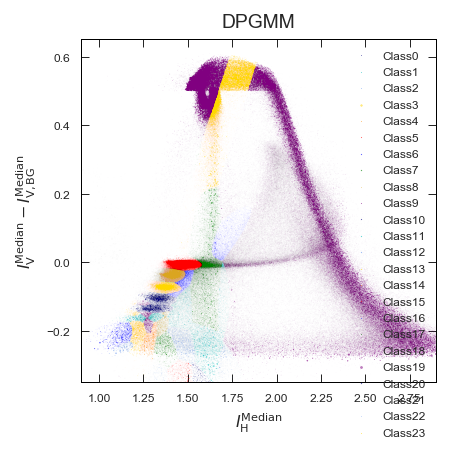

In [41]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'r', 'b','g', 'goldenrod', 'purple'])

plt.figure(figsize=cm2inch(8,8))
ax = plt.subplot(111)
for i, (mean, color) in enumerate(zip(dpgmm.means_, color_iter)):
    ax.scatter(X_to_predict[class_ind==i,1],
               X_to_predict[class_ind==i,0],
               s=(Area_to_predict[class_ind==i]/400000),
               alpha=0.5, 
               color=color,
               label='Class%d'%i)
    
ax.set_title('DPGMM')
ax.set_xlabel('$\mathit{I}^\mathrm{Median}_\mathrm{H}$')
ax.set_ylabel('$\mathit{I}^\mathrm{Median}_\mathrm{V} - \mathit{I}^\mathrm{Median}_\mathrm{V, BG}$')
ax.set_xlim(0.9,2.9)
ax.set_ylim(-0.35,0.65)
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('Figure6.png')
plt.show()

In [42]:
if opt_outp_images:
    area_th = 500
    for i in range(class_ind.max()+1):
        df2 = df[df['class_index']==i]
        outp_images_with_mark(df2[area_th < df2['area']], 'DPGMM_group_' + index_str[i] + '_')

In [43]:
#for i, (mean, color) in enumerate(zip(dpgmm.means_, color_iter)):
#    df[df['class_index']==i]['filename'].to_csv('class%d_filename.csv'%i)
#    df[df['class_index']==i]['column'].to_csv('class%d_column.csv'%i)
#    df[df['class_index']==i]['row'].to_csv('class%d_row.csv'%i)